In [ ]:
import numpy as np
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import wrds
#db=wrds.Connection(wrds_username='sahakyan')

# 3 Betting against Beta strategy (BaB)

#### (a) Computation of time-varying Beta

In [2]:
# load data
data = pd.read_csv('data.csv', sep=';')
data['date'] = pd.to_datetime(data['date'])
# get rid of the day in the date
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()

In [3]:
data = data.sort_values(by=['permno', 'date']).reset_index(drop=True)

In [4]:
# (a)
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(window = 60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge betas with data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = data.merge(beta_n, on=['permno','date'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))

In [5]:
len(data)

1118617

#### (B) Beta Deciles

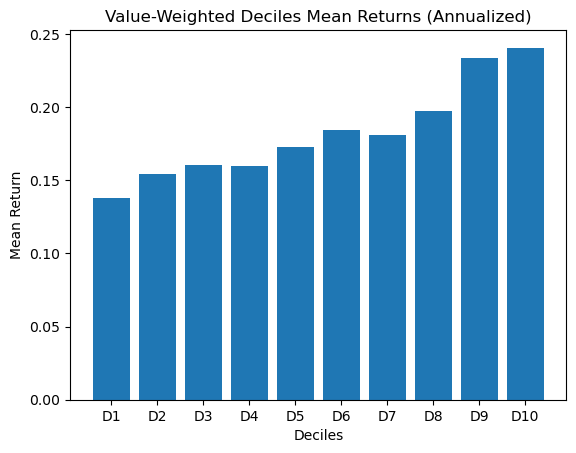

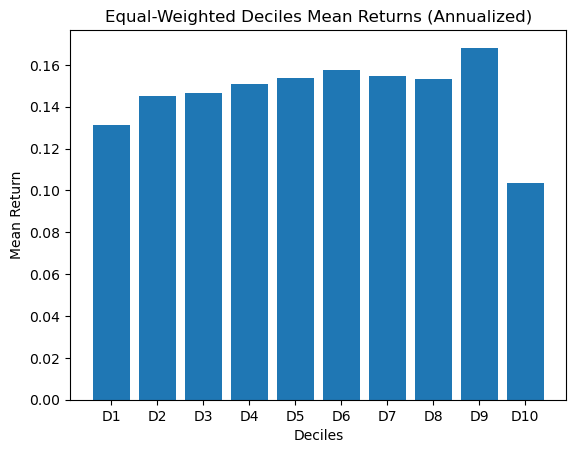

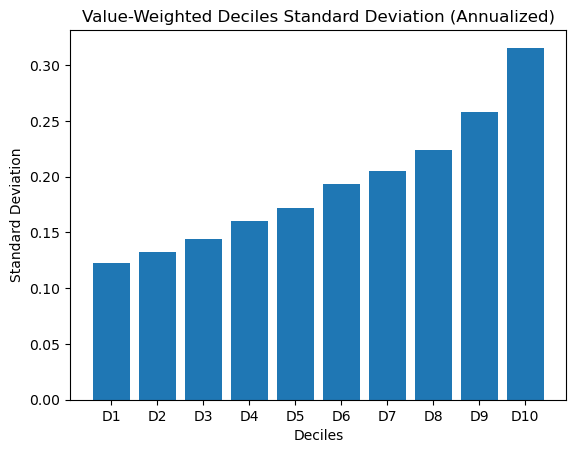

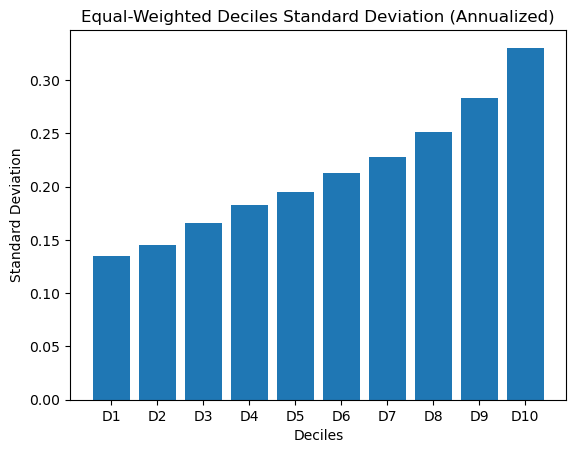

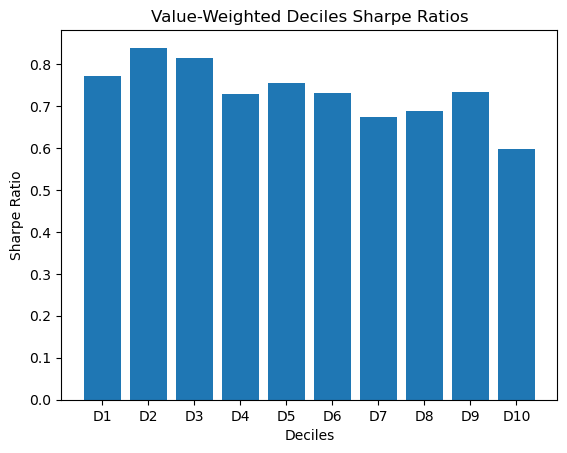

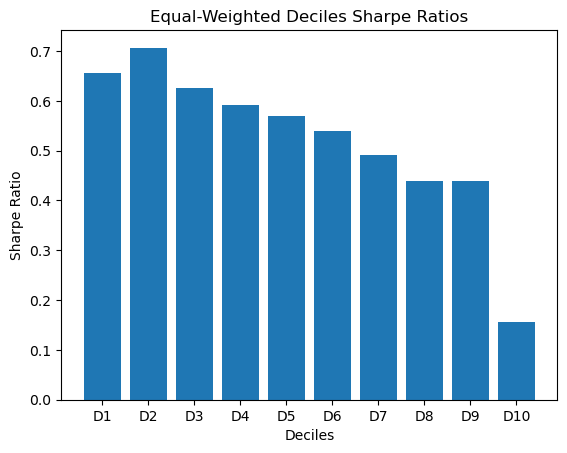

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# (b)
# 1. Deciles
data['beta_Q'] = data.groupby('date')['beta'].transform(lambda x: pd.qcut(x, 10, labels=False, duplicates='drop'))
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap'] / data.groupby(['date', 'beta_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['beta_ret_vw'] = data['vw_Q'] * data['Rn']
ret_vw = data.groupby(['date', 'beta_Q'])['beta_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('beta_Q')['beta_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date', 'beta_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('beta_Q')['Rn'].mean()

# Calculate standard deviations
vw_ret_std = ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_ret_std = ret_ew.groupby('beta_Q')['Rn'].std()

# Compute the Sharpe Ratios for each decile

# compute the risk-free rate
rf = data.groupby(['date', 'beta_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['beta_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe = ret_vw.groupby('beta_Q')['excess'].mean() / ret_vw.groupby('beta_Q')['beta_ret_vw'].std()
ew_sharpe = ret_ew.groupby('beta_Q')['excess'].mean() / ret_ew.groupby('beta_Q')['Rn'].std()

# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part3'

#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + '/vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + '/ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + '/vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + '/ew_ret_std.png')
plt.show()

# Plot VW Sharpe Ratios
plt.bar(deciles, vw_sharpe* np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + '/vw_sharpe.png')
plt.show()

# Plot EW Sharpe Ratios
plt.bar(deciles, ew_sharpe* np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + '/ew_sharpe.png')
plt.show()

TODO
- Question: Summarize our findings. Is the evidence consistent with the CAPM?
- Answer:

#### (c/d) Construct BAB factor

In [7]:
# Weights
data['z'] = data.groupby('date')['beta'].transform(lambda x: x.rank())
data['z_'] = data['z']-data.groupby('date')['z'].transform('mean')
data['k'] = np.abs(data['z_'])
data['k'] = 2/data.groupby('date')['k'].transform('sum')
data['w_H'] = data['k'] * data['z_'] * (data['z_']>0) 
data['w_L'] = -data['k'] * data['z_'] * (data['z_']<0) 

# Weighted returns and beta
data['beta_H'] = data['w_H'] * data['beta']
data['beta_L'] = data['w_L'] * data['beta']
data['R_H'] = data['w_H'] * data['Rn']
data['R_L'] = data['w_L'] * data['Rn']
data['R_H_e'] = data['w_H'] * data['Rn_e']
data['R_L_e'] = data['w_L'] * data['Rn_e']

# Sum up the weighted returns and betas but not the rf
BAB = data.groupby('date')[['R_H','R_L','R_H_e','R_L_e','beta_H','beta_L']].sum().reset_index()
BAB['rf'] = data.groupby('date')['rf'].mean().reset_index()['rf']
# unlevered returns
BAB['BAB2'] = (BAB['R_L_e']/BAB['beta_L']) - ( BAB['R_H_e']/BAB['beta_H'] )


In [8]:
# Merge Market and Risk free Rate
tmp = pd.merge(BAB,data[['date','Rm_e']].drop_duplicates(), on=['date'], how='left')
tmp['alpha'] = 1

# Alpha and Beta
import statsmodels.api as sm
tmp = tmp.dropna()
OLS_Reg = sm.OLS(tmp['BAB2'], tmp[['alpha','Rm_e']]).fit()

# Report the mean,standard deviation, and sharpe ratio and CAPM alpha of the BAB factor
print('Mean:', tmp['BAB2'].mean()*12)
print('Standard Deviation:', tmp['BAB2'].std()*np.sqrt(12))
# Annualize the Sharpe ratio and CAPM alpha
print('Sharpe ratio:', tmp['BAB2'].mean()/tmp['BAB2'].std()*np.sqrt(12))
print('Monthly CAPM Alpha:', OLS_Reg.params['alpha']*12)



Mean: 0.11863646713386436
Standard Deviation: 0.14072744446597016
Sharpe ratio: 0.8430229624652373
Monthly CAPM Alpha: 0.0832411358896345


Save factor for our investing strategy

In [9]:
print(len(BAB))
strat = BAB[['date','rf','BAB2']]
strat

682


,date,rf,BAB2
0,1967-01-01,0.003788,0.074347
1,1967-02-01,0.003737,0.017428
2,1967-03-01,0.003385,0.012772
3,1967-04-01,0.002877,0.022509
4,1967-05-01,0.002707,0.004912
...,...,...,...
677,2023-08-01,0.004463,-0.015503
678,2023-09-01,0.004472,-0.043713
679,2023-10-01,0.004475,0.005500
680,2023-11-01,0.004455,0.035030


# 4 Momentum Strategy (Mom)

In [10]:
# Load data
data = pd.read_csv('data.csv', delimiter=';')
#drop column mcap_l 
data = data.drop(columns=['mcap_l'])
#drop nan in Rn column
data = data.dropna(subset=['Rn'])
# Convert date to datetime
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()
# Sort the data by permno and date
data = data.sort_values(['permno', 'date']).reset_index(drop=True)
display(data.isna().sum())
data

permno       0
date         0
Rn           0
shrout       0
prc          0
mcap         0
rf        2076
Rm           0
const        0
Rn_e      2076
Rm_e      2076
dtype: int64

,permno,date,Rn,shrout,prc,mcap,rf,Rm,const,Rn_e,Rm_e
0,10001,2009-12-01,0.162621,4361.0,10.3000,44918.3000,0.000032,0.028475,1,0.162589,0.028443
1,10001,2010-01-01,-0.018932,4361.0,10.0600,43871.6600,0.000013,-0.037172,1,-0.018945,-0.037185
2,10001,2010-02-01,-0.000656,4361.0,10.0084,43646.6324,0.000061,0.034744,1,-0.000717,0.034683
3,10001,2010-03-01,0.020643,4361.0,10.1700,44351.3700,0.000112,0.063668,1,0.020531,0.063556
4,10001,2010-04-01,0.124385,6070.0,11.3900,69137.3000,0.000118,0.020036,1,0.124267,0.019918
...,...,...,...,...,...,...,...,...,...,...,...
1432773,93426,2023-08-01,-0.037156,12581.0,36.0200,453167.6200,0.004463,-0.020605,1,-0.041619,-0.025068
1432774,93426,2023-09-01,-0.067740,12581.0,33.5800,422469.9800,0.004472,-0.047390,1,-0.072212,-0.051862
1432775,93426,2023-10-01,-0.108993,12581.0,29.9200,376423.5200,0.004475,-0.028867,1,-0.113468,-0.033342
1432776,93426,2023-11-01,0.019051,12510.0,30.4900,381429.9000,0.004455,0.092057,1,0.014596,0.087602


In [11]:
data['LN_Cret12'] = data.groupby('permno').apply(lambda x: np.log(x.Rn+1).rolling(11, min_periods = 11, closed='left').sum()).values

# shift the LN_Cret12 column by 1
data['LN_Cret12'] = data.groupby('permno')['LN_Cret12'].shift(1)
data.dropna(subset=['LN_Cret12'], inplace=True)

q = 10
data['Momentum'] = data.groupby('date')['LN_Cret12'].transform(lambda x: pd.qcut(x,q,labels=False, duplicates='drop'))
data

,permno,date,Rn,shrout,prc,mcap,rf,Rm,const,Rn_e,Rm_e,LN_Cret12,Momentum
12,10001,2010-12-01,0.052291,7834.0,10.52,82413.68,0.000068,0.067182,1,0.052223,0.067114,0.297149,7
13,10001,2011-01-01,0.028992,7834.0,10.78,84450.52,0.000125,0.019183,1,0.028867,0.019058,0.020414,3
14,10001,2011-02-01,0.022727,7834.0,10.98,86017.32,0.000065,0.038156,1,0.022662,0.038091,0.090498,2
15,10001,2011-03-01,0.072404,7834.0,11.73,91892.82,0.000049,0.003341,1,0.072355,0.003292,0.119734,3
16,10001,2011-04-01,-0.038789,8151.0,11.23,91535.73,0.000013,0.028597,1,-0.038802,0.028584,0.121773,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1432773,93426,2023-08-01,-0.037156,12581.0,36.02,453167.62,0.004463,-0.020605,1,-0.041619,-0.025068,0.175187,7
1432774,93426,2023-09-01,-0.067740,12581.0,33.58,422469.98,0.004472,-0.047390,1,-0.072212,-0.051862,0.086501,5
1432775,93426,2023-10-01,-0.108993,12581.0,29.92,376423.52,0.004475,-0.028867,1,-0.113468,-0.033342,0.196638,5
1432776,93426,2023-11-01,0.019051,12510.0,30.49,381429.90,0.004455,0.092057,1,0.014596,0.087602,-0.005050,5


In [12]:
# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','Momentum'])['mcap'].transform('sum')

# 3. VW Portfolios
data['MOM_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','Momentum'])['MOM_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('Momentum')['MOM_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','Momentum'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('Momentum')['Rn'].mean()

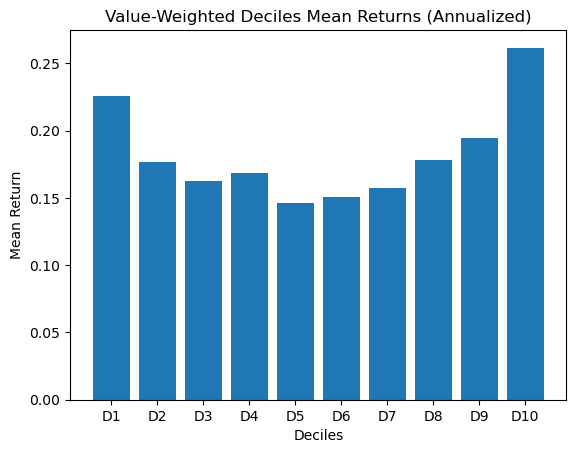

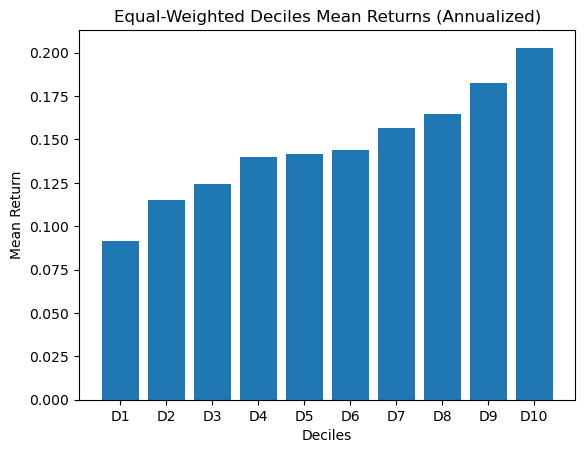

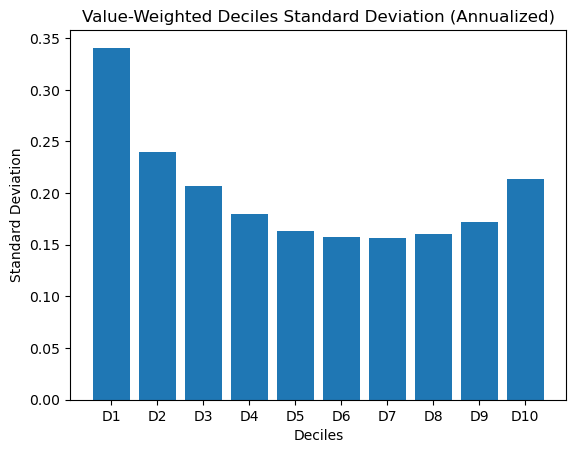

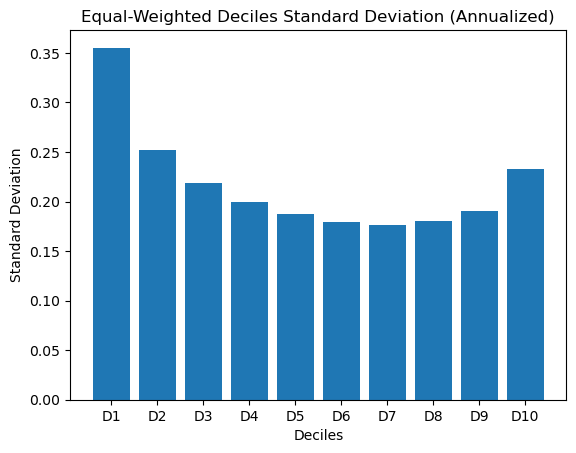

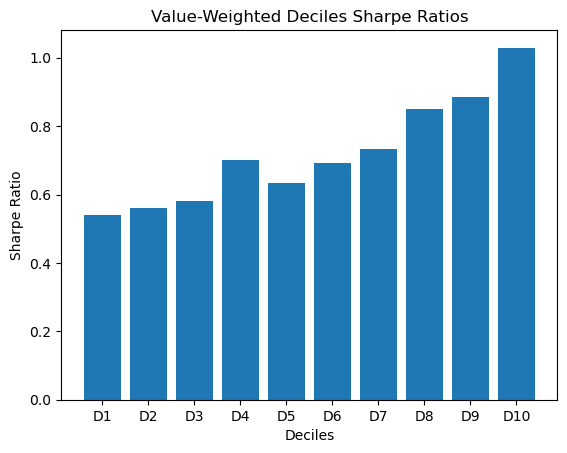

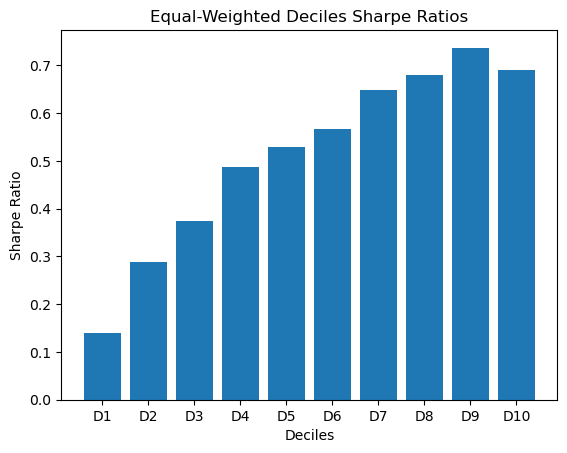

In [13]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('Momentum')['MOM_ret_vw'].std()
ew_ret_std = ret_ew.groupby('Momentum')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['MOM_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('Momentum')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('Momentum')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part4/'
#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'ew_ret_std.png')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'vw_sharpe_ratio.png')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'ew_sharpe_ratio.png')
plt.show()

### Factor creation

#### Equal-Weighted Long-Short Factor Strategy

In [14]:
# 1. Compute the long and short legs of the strategy
ew_long_leg = data[data['Momentum'] >= 7].groupby('date')['Rn'].mean().reset_index()
ew_short_leg = data[data['Momentum'] < 3].groupby('date')['Rn'].mean().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

ew_long_leg['excess'] = ew_long_leg['Rn'] - rf['rf']
ew_short_leg['excess'] = ew_short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = ew_long_leg['Rn'].mean() * 12
short_mean = ew_short_leg['Rn'].mean() * 12

long_mean_e = ew_long_leg['excess'].mean() * 12
short_mean_e = ew_short_leg['excess'].mean() * 12

long_std = ew_long_leg['Rn'].std() * np.sqrt(12)
short_std = ew_short_leg['Rn'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = ew_long_leg.set_index("date") - ew_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['Rn'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.18350733603678704
Short Leg Mean Return: 0.11027267804475926
Long Leg Standard Deviation: 0.19754548661402654
Short Leg Standard Deviation: 0.26801944208572653
Long Leg Sharpe Ratio: 0.6729883134654516
Short Leg Sharpe Ratio: 0.2306584526124965
Factor Mean Return: 0.0732346579920278
Factor Standard Deviation: 0.16759144585139973
Factor Sharpe Ratio: 0.12694277257062728


In [15]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 11.62736856127751
P-Value: 0.0
The factor strategy has an average return that is statistically significantly different from zero.


#### Value-Weighted Long-Short Factor Strategy

In [16]:
#1. Compute the long and short legs of the strategy
vw_long_leg = data[data['Momentum'] >= 7].groupby('date')['MOM_ret_vw'].sum().reset_index()
vw_short_leg = data[data['Momentum'] < 3].groupby('date')['MOM_ret_vw'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'Momentum'])['rf'].mean().reset_index()

vw_long_leg['excess'] = vw_long_leg['MOM_ret_vw'] - rf['rf']
vw_short_leg['excess'] = vw_short_leg['MOM_ret_vw'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = vw_long_leg['MOM_ret_vw'].mean() * 12
short_mean = vw_short_leg['MOM_ret_vw'].mean() * 12

long_mean_e = vw_long_leg['excess'].mean() * 12
short_mean_e = vw_short_leg['excess'].mean() * 12

long_std = vw_long_leg['MOM_ret_vw'].std() * np.sqrt(12)
short_std = vw_short_leg['MOM_ret_vw'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['MOM_ret_vw'] - rf['rf']

factor_mean = factor['MOM_ret_vw'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['MOM_ret_vw'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.6340091384139981
Short Leg Mean Return: 0.5653608046375727
Long Leg Standard Deviation: 0.5203221746117288
Short Leg Standard Deviation: 0.7494202595343373
Long Leg Sharpe Ratio: 1.1237958073731082
Short Leg Sharpe Ratio: 0.6791625155060891
Factor Mean Return: 0.06864833377642544
Factor Standard Deviation: 0.6036593434130313
Factor Sharpe Ratio: 0.042917249051169004


In [17]:
# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')

T-Statistic: 3.0259009130207817
P-Value: 0.0012394676252024395
The factor strategy has an average return that is statistically significantly different from zero.


In [18]:
# Merge factor dataframe with strat dataframe
strat = strat.merge(factor[['date','MOM_ret_vw']], on='date', how='left')

In [19]:
strat

,date,rf,BAB2,MOM_ret_vw
0,1967-01-01,0.003788,0.074347,-0.244450
1,1967-02-01,0.003737,0.017428,0.076805
2,1967-03-01,0.003385,0.012772,0.049046
3,1967-04-01,0.002877,0.022509,-0.017797
4,1967-05-01,0.002707,0.004912,0.053441
...,...,...,...,...
677,2023-08-01,0.004463,-0.015503,0.172734
678,2023-09-01,0.004472,-0.043713,0.018452
679,2023-10-01,0.004475,0.005500,-0.026999
680,2023-11-01,0.004455,0.035030,0.051445


# 5 Idiosyncratic Volatility Strategy (IV)

In [20]:
data = pd.read_csv("data.csv",sep=";")
data['date'] = pd.to_datetime(data['date'])
data['date'] = data['date'].dt.to_period('M')
data['date'] = data['date'].dt.to_timestamp()
# sort the data by date inside each permno
data = data.sort_values(by=['permno','date']).reset_index(drop=True)

In [21]:
# 0. Remove nans
data = data.dropna(subset=['mcap_l','Rn_e','Rm_e']).copy()

# 2. Estimate Rolling Betas
cov_nm = data.set_index('date').groupby('permno')[['Rn_e','Rm_e']].rolling(60, min_periods=36).cov()
beta_n = (cov_nm.iloc[0::2,1].droplevel(2)/cov_nm.iloc[1::2,1].droplevel(2))
beta_n = beta_n.dropna().reset_index().rename(columns={'Rm_e':'beta'})

# 3. Merge With data
beta_n['date'] = beta_n['date'] + pd.DateOffset(months=1)
data = pd.merge(data, beta_n, on=['date','permno'], how='left')

# get rid of nan values
data = data.dropna(subset=['beta']).copy()

# 4. Remove outliers
data['beta'] = data['beta'].clip(data['beta'].quantile(0.05),data['beta'].quantile(0.95))

In [22]:
data

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,beta
36,10001,2013-01-01,0.062701,8157.0,9.87,80509.59,81080.58,0.000051,0.054142,1,0.062650,0.054091,0.464682
37,10001,2013-02-01,0.011651,8157.0,9.94,81080.58,83201.40,0.000040,0.008282,1,0.011611,0.008242,0.484416
38,10001,2013-03-01,0.030684,8157.0,10.20,83201.40,86668.70,0.000034,0.035295,1,0.030650,0.035261,0.484182
39,10001,2013-04-01,0.017157,8390.0,10.33,86668.70,86249.20,0.000013,0.014939,1,0.017144,0.014926,0.487155
40,10001,2013-05-01,-0.000484,8390.0,10.28,86249.20,89064.10,0.000013,0.019128,1,-0.000497,0.019115,0.487298
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1420784,93426,2023-08-01,-0.037156,12581.0,36.02,453167.62,422469.98,0.004463,-0.020605,1,-0.041619,-0.025068,1.312988
1420785,93426,2023-09-01,-0.067740,12581.0,33.58,422469.98,376423.52,0.004472,-0.047390,1,-0.072212,-0.051862,1.306562
1420786,93426,2023-10-01,-0.108993,12581.0,29.92,376423.52,381429.90,0.004475,-0.028867,1,-0.113468,-0.033342,1.299385
1420787,93426,2023-11-01,0.019051,12510.0,30.49,381429.90,426215.70,0.004455,0.092057,1,0.014596,0.087602,1.300548


In [23]:
# 5. Calculate IV:
# Calculate the predicted return
data['predicted_return_e'] = data['beta'] * data['Rm_e']

# Calculate the residuals
data['residuals'] = data['Rn_e'] - data['predicted_return_e']

# Calculate the rolling standard deviation of the residuals
idiosyncratic_volatility = data.set_index('date').groupby('permno')['residuals'].rolling(window=60, min_periods=36).std()

# Reset the index of the idiosyncratic_volatility Series
idiosyncratic_volatility = idiosyncratic_volatility.reset_index()

# Rename the 0 column to 'idiosyncratic_volatility'
idiosyncratic_volatility = idiosyncratic_volatility.rename(columns={"residuals": 'idiosyncratic_volatility'})

# Merge the idiosyncratic_volatility DataFrame with the original data DataFrame
data = pd.merge(data, idiosyncratic_volatility, on=['date', 'permno'], how='left')

# Drop the intermediate columns
data = data.drop(columns=['predicted_return_e', 'residuals'])

# Drop nans in the idiosyncratic_volatility and beta columns
data = data.dropna(subset=['idiosyncratic_volatility'])

# 4. Remove outliers
data['idiosyncratic_volatility'] = data['idiosyncratic_volatility'].clip(data['idiosyncratic_volatility'].quantile(0.05),data['idiosyncratic_volatility'].quantile(0.95))

In [24]:
data

,permno,date,Rn,shrout,prc,mcap,mcap_l,rf,Rm,const,Rn_e,Rm_e,beta,idiosyncratic_volatility
35,10001,2015-12-01,-0.132151,10505.0,7.45,78262.25,87401.60,0.000057,-0.022209,1,-0.132208,-0.022266,0.257583,0.073474
36,10001,2016-01-01,0.116779,10505.0,8.32,87401.60,82569.30,0.000190,-0.057085,1,0.116589,-0.057275,0.257583,0.075759
37,10001,2016-02-01,-0.055288,10505.0,7.86,82569.30,82067.48,0.000186,0.000620,1,-0.055474,0.000434,0.257583,0.075274
38,10001,2016-03-01,-0.006361,10508.0,7.81,82067.48,76737.60,0.000063,0.070491,1,-0.006424,0.070428,0.257583,0.074371
39,10001,2016-04-01,-0.055698,10512.0,7.30,76737.60,75055.68,0.000110,0.011718,1,-0.055808,0.011608,0.257583,0.073961
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1118612,93426,2023-08-01,-0.037156,12581.0,36.02,453167.62,422469.98,0.004463,-0.020605,1,-0.041619,-0.025068,1.312988,0.064385
1118613,93426,2023-09-01,-0.067740,12581.0,33.58,422469.98,376423.52,0.004472,-0.047390,1,-0.072212,-0.051862,1.306562,0.062242
1118614,93426,2023-10-01,-0.108993,12581.0,29.92,376423.52,381429.90,0.004475,-0.028867,1,-0.113468,-0.033342,1.299385,0.062429
1118615,93426,2023-11-01,0.019051,12510.0,30.49,381429.90,426215.70,0.004455,0.092057,1,0.014596,0.087602,1.300548,0.063323


### Sorting

In [25]:
data['IV_Q'] = data.groupby('date')['idiosyncratic_volatility'].transform(lambda x: pd.qcut(x, 10,labels=False, duplicates='drop'))

# 2. Market Weights within deciles
data['vw_Q'] = data['mcap']/data.groupby(['date','IV_Q'])['mcap'].transform('sum')

# 3. VW Portfolios
data['IV_ret_vw'] = data['vw_Q']*data['Rn']
ret_vw = data.groupby(['date','IV_Q'])['IV_ret_vw'].sum().reset_index()
vw_ret_mean = ret_vw.groupby('IV_Q')['IV_ret_vw'].mean()

# 4. Equal-Weighted portfolios
ret_ew = data.groupby(['date','IV_Q'])['Rn'].mean().reset_index()
ew_ret_mean = ret_ew.groupby('IV_Q')['Rn'].mean()

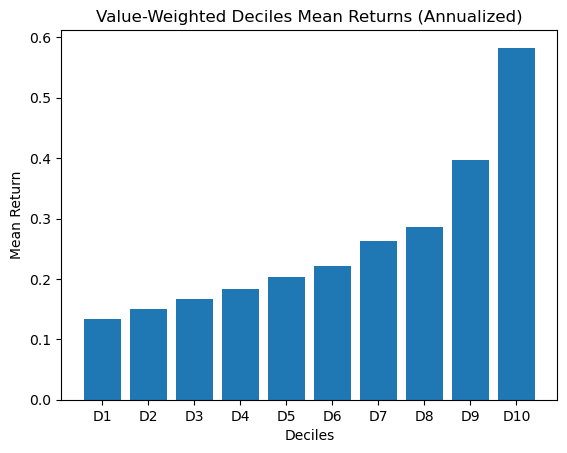

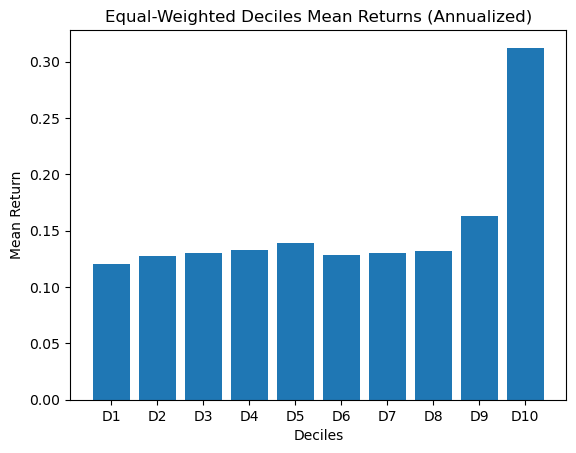

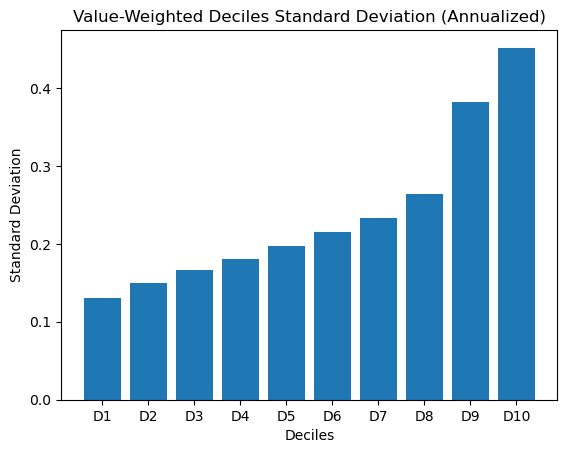

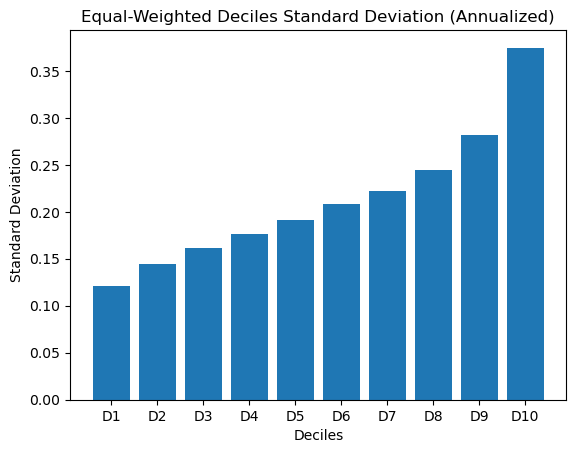

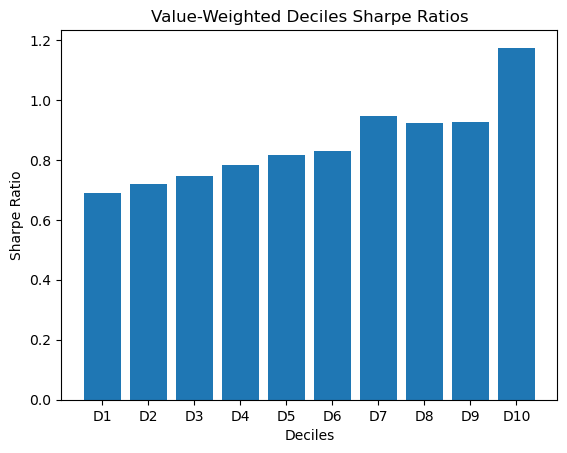

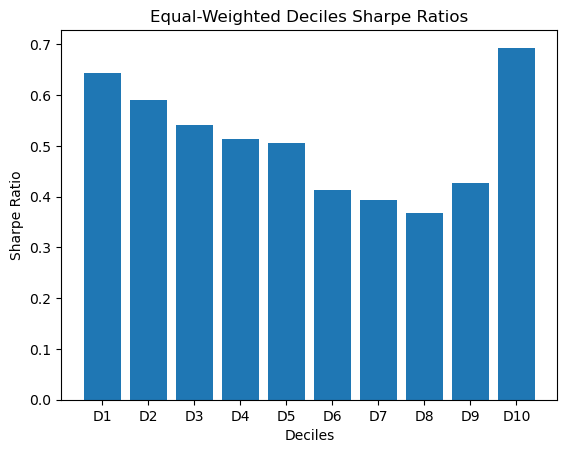

In [26]:
# Calculate standard deviations
vw_ret_std = ret_vw.groupby('IV_Q')['IV_ret_vw'].std()
ew_ret_std = ret_ew.groupby('IV_Q')['Rn'].std()

# Calculate Sharpe Ratios

# compute the risk-free rate
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

# compute the excess returns
ret_vw['excess'] = ret_vw['IV_ret_vw'] - rf['rf']
ret_ew['excess'] = ret_ew['Rn'] - rf['rf']

# compute the Sharpe Ratios
vw_sharpe_ratio = ret_vw.groupby('IV_Q')['excess'].mean() / vw_ret_std
ew_sharpe_ratio = ret_ew.groupby('IV_Q')['excess'].mean() / ew_ret_std


# 5. Plot Histograms
deciles = ['D' + str(x) for x in np.arange(1, 11)]

directory = 'Plots/Part5/'
#save plots
# Plot VW mean returns
plt.bar(deciles, vw_ret_mean * 12)
plt.title('Value-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'vw_ret_mean.png')
plt.show()

# Plot EW mean returns
plt.bar(deciles, ew_ret_mean * 12)
plt.title('Equal-Weighted Deciles Mean Returns (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Mean Return')
plt.savefig(directory + 'ew_ret_mean.png')
plt.show()

# Plot VW standard deviations
plt.bar(deciles, vw_ret_std * np.sqrt(12))
plt.title('Value-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'vw_ret_std.png')
plt.show()

# Plot EW standard deviations
plt.bar(deciles, ew_ret_std * np.sqrt(12))
plt.title('Equal-Weighted Deciles Standard Deviation (Annualized)')
plt.xlabel('Deciles')
plt.ylabel('Standard Deviation')
plt.savefig(directory + 'ew_ret_std.png')
plt.show()

# Plot VW Sharpe ratios
plt.bar(deciles, vw_sharpe_ratio * np.sqrt(12))
plt.title('Value-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'vw_sharpe_ratio.png')
plt.show()

# Plot EW Sharpe ratios
plt.bar(deciles, ew_sharpe_ratio * np.sqrt(12))
plt.title('Equal-Weighted Deciles Sharpe Ratios')
plt.xlabel('Deciles')
plt.ylabel('Sharpe Ratio')
plt.savefig(directory + 'ew_sharpe_ratio.png')
plt.show()

### Factor creation

Equally weighted factor strategy

In [27]:
# 1. Compute the long and short legs of the strategy
long_leg = data[data['IV_Q'] >= 7].groupby('date')['Rn'].mean().reset_index()
short_leg = data[data['IV_Q'] < 3].groupby('date')['Rn'].mean().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

long_leg['excess'] = long_leg['Rn'] - rf['rf']
short_leg['excess'] = short_leg['Rn'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = long_leg['Rn'].mean() * 12
short_mean = short_leg['Rn'].mean() *12

long_mean_e = long_leg['excess'].mean() *12
short_mean_e = short_leg['excess'].mean() * 12

long_std = long_leg['Rn'].std() * np.sqrt(12)
short_std = short_leg['Rn'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = long_leg.set_index("date") - short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['Rn'] - rf['rf']

factor_mean = factor['Rn'].mean() * 12
factor_mean_e = factor['excess'].mean() * 12
factor_std = factor['Rn'].std() * np.sqrt(12)
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 0.18855836045876379
Short Leg Mean Return: 0.12688566286024472
Long Leg Standard Deviation: 0.2847125619436325
Short Leg Standard Deviation: 0.13860733143297563
Long Leg Sharpe Ratio: 0.4654611949030064
Short Leg Sharpe Ratio: 0.5111558743335318
Factor Mean Return: 0.06167269759851912
Factor Standard Deviation: 0.20246862875493477
Factor Sharpe Ratio: 0.027841283168651424


Save factor for our investing strategy

In [28]:
import scipy.stats as stats

# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')


T-Statistic: 7.747959535495736
P-Value: 4.6629367034256575e-15
The factor strategy has an average return that is statistically significantly different from zero.


Value weighted factor strategy

In [29]:
#1. Compute the long and short legs of the strategy
vw_long_leg = data[data['IV_Q'] >= 7].groupby('date')['IV_ret_vw'].sum().reset_index()
vw_short_leg = data[data['IV_Q'] < 3].groupby('date')['IV_ret_vw'].sum().reset_index()

# 2. Compute the excess returns
rf = data.groupby(['date', 'IV_Q'])['rf'].mean().reset_index()

vw_long_leg['excess'] = vw_long_leg['IV_ret_vw'] - rf['rf']
vw_short_leg['excess'] = vw_short_leg['IV_ret_vw'] - rf['rf']

# 3. Compute the mean, excess mean, standard deviation, and Sharpe ratios
long_mean = vw_long_leg['IV_ret_vw'].mean() * 12
short_mean = vw_short_leg['IV_ret_vw'].mean() * 12

long_mean_e = vw_long_leg['excess'].mean() * 12
short_mean_e = vw_short_leg['excess'].mean() * 12

long_std = vw_long_leg['IV_ret_vw'].std() * np.sqrt(12)
short_std = vw_short_leg['IV_ret_vw'].std() * np.sqrt(12)

long_sharpe_ratio = long_mean_e / long_std
short_sharpe_ratio = short_mean_e / short_std

# Long minus short factor strategy
factor = vw_long_leg.set_index("date") - vw_short_leg.set_index("date")
factor = factor.reset_index()
factor['excess'] = factor['IV_ret_vw'] - rf['rf']

factor_mean = factor['IV_ret_vw'].mean()
factor_mean_e = factor['excess'].mean()
factor_std = factor['IV_ret_vw'].std()
factor_sharpe_ratio = factor_mean_e / factor_std

# 4. Print the results
print('Long Leg Mean Return:', long_mean)
print('Short Leg Mean Return:', short_mean)
print('Long Leg Standard Deviation:', long_std)
print('Short Leg Standard Deviation:', short_std)
print('Long Leg Sharpe Ratio:', long_sharpe_ratio)
print('Short Leg Sharpe Ratio:', short_sharpe_ratio)
print('Factor Mean Return:', factor_mean)
print('Factor Standard Deviation:', factor_std)
print('Factor Sharpe Ratio:', factor_sharpe_ratio)

Long Leg Mean Return: 1.1250145856561555
Short Leg Mean Return: 0.4490560646888113
Long Leg Standard Deviation: 0.9051887199027854
Short Leg Standard Deviation: 0.43315898539215764
Long Leg Sharpe Ratio: 1.1809458635303984
Short Leg Sharpe Ratio: 0.907335105054807
Factor Mean Return: 0.05632987674727867
Factor Standard Deviation: 0.20616199243972372
Factor Sharpe Ratio: 0.2505807861973753


In [30]:
# Test if the factor strategy has an average return that is statistically significantly different from zero

# 1. Compute the t-statistic
t_stat = factor_mean / (factor_std / np.sqrt(len(factor)))

# 2. Compute the p-value
p_value = 1 - stats.norm.cdf(t_stat)

# 3. Print the results
print('T-Statistic:', t_stat)
print('P-Value:', p_value)

# 4. Check if the p-value is less than 0.05
if p_value < 0.05:
    print('The factor strategy has an average return that is statistically significantly different from zero.')
else:
    print('The factor strategy does not have an average return that is statistically significantly different from zero.')

T-Statistic: 6.949960535940304
P-Value: 1.8269830093231576e-12
The factor strategy has an average return that is statistically significantly different from zero.


In [31]:
# Merge factor dataframe with strat dataframe

strat = strat.merge(factor[['date','IV_ret_vw']], on='date', how='left')

# Drop all nans
strat = strat.dropna()

In [32]:
# rename columns to IV and MOM
strat = strat.rename(columns={'IV_ret_vw':'IV','MOM_ret_vw':'MOM'})
strat

,date,rf,BAB2,MOM,IV
35,1970-02-01,0.005253,0.028449,0.045441,0.430873
36,1970-03-01,0.005345,0.027153,0.070217,-0.122465
37,1970-04-01,0.005427,-0.040410,0.174635,-0.412359
38,1970-05-01,0.005257,-0.052268,0.005201,-0.126123
39,1970-06-01,0.004942,0.006999,0.201597,-0.100516
...,...,...,...,...,...
677,2023-08-01,0.004463,-0.015503,0.172734,0.027812
678,2023-09-01,0.004472,-0.043713,0.018452,0.027855
679,2023-10-01,0.004475,0.005500,-0.026999,-0.064254
680,2023-11-01,0.004455,0.035030,0.051445,-0.054103


In [33]:
strat.to_csv('strat.csv', sep=';',index=False) # export data

In [34]:
# read csv
strat = pd.read_csv('strat.csv', sep=';')

# 6 Optimal Fund Portfolio Return (STRAT)

In [45]:
# Equal weight strategy
strat['STRAT1'] = (strat['BAB2'] + strat['IV'] + strat['MOM'])/3

# Window size equal to data length
number_of_rows = len(strat)


# Risk-Parity strategy
rolling_vol = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60,min_periods=36).std()
weights = 1 / rolling_vol
# Normalize the weights
weights = weights.div(weights.sum(axis=1), axis=0)
strat['STRAT2'] = (weights['BAB2'] * strat['BAB2'] + weights['IV'] * strat['IV'] + weights['MOM'] * strat['MOM'])

# Mean-variance optimal combination
rolling_mean = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).mean()
rolling_cov = strat[['BAB2', 'IV', 'MOM']].rolling(window = 60, min_periods=36).cov()

# w_tan = Cov^(-1) * (mu - Rf * 1) / 1.T * Cov^(-1) * (mu - Rf * 1)

# Iterate over the rolling windows
optimal_weights = []
for i in range(number_of_rows):
    mu = rolling_mean.iloc[i].values
    cov = rolling_cov.loc[rolling_cov.index.get_level_values(0) == i].droplevel(0)
    ones = np.ones(len(mu))
    rf = strat['rf'].iloc[i]
    w_tan = np.linalg.inv(cov).dot((mu - rf * ones)) / (ones.T.dot(np.linalg.inv(cov).dot((mu - rf * ones))))
    optimal_weights.append(w_tan)

optimal_weights = pd.DataFrame(optimal_weights, columns = ['BAB2', 'IV', 'MOM'])
strat['STRAT3'] = (optimal_weights['BAB2'] * strat['BAB2'] + optimal_weights['IV'] * strat['IV'] + optimal_weights['MOM'] * strat['MOM'])

In [46]:
# Calculate the annualized volatility and mean of the STRAT1, STRAT2, and STRAT3 strategies
strat1_mean = strat['STRAT1'].mean() * 12
strat1_std = strat['STRAT1'].std() * np.sqrt(12)
excess_strat1 = strat['STRAT1'] - strat['rf']
strat1_sharpe = excess_strat1.mean() / strat["STRAT1"].std() * np.sqrt(12)

strat2_mean = strat['STRAT2'].mean() * 12
strat2_std = strat['STRAT2'].std() * np.sqrt(12)
excess_strat2 = strat['STRAT2'] - strat['rf']
strat2_sharpe = excess_strat2.mean() / strat["STRAT2"].std() * np.sqrt(12)

strat3_mean = strat['STRAT3'].mean() * 12
strat3_std = strat['STRAT3'].std() * np.sqrt(12)
excess_strat3 = strat['STRAT3'] - strat['rf']
strat3_sharpe = excess_strat3.mean() / strat["STRAT3"].std() * np.sqrt(12)

# Print the results
print('Equal Weighted Strategy:')
print('Mean:', strat1_mean)
print('Standard Deviation:', strat1_std)
print('Sharpe Ratio:', strat1_sharpe)
print("\n")

print('Risk-Parity Strategy:')
print('Mean:', strat2_mean)
print('Standard Deviation:', strat2_std)
print('Sharpe Ratio:', strat2_sharpe)
print("\n")

print('Mean-Variance Optimal Strategy:')
print('Mean:', strat3_mean)
print('Standard Deviation:', strat3_std)
print('Sharpe Ratio:', strat3_sharpe)

Equal Weighted Strategy:
Mean: 0.27260533626158867
Standard Deviation: 0.2630730131728023
Sharpe Ratio: 0.8746302378094861


Risk-Parity Strategy:
Mean: 0.1853546154028831
Standard Deviation: 0.1548084697375587
Sharpe Ratio: 0.9237176007987224


Mean-Variance Optimal Strategy:
Mean: -0.2451294692942389
Standard Deviation: 3.518609253155731
Sharpe Ratio: -0.08170409265819627


In [39]:
# Now find c such that the average annual volatility of the fund is 10% in each case
c1 = 0.1 / strat1_std
c2 = 0.1 / strat2_std
c3 = 0.1 / strat3_std

# Calculate the fund returns
strat['fund1'] = strat['rf'] + c1 * strat['STRAT1']
strat['fund2'] = strat['rf'] + c2 * strat['STRAT2']
strat['fund3'] = strat['rf'] + c3 * strat['STRAT3']

# Calculate the annualized volatility and mean of the fund returns
fund1_mean = strat['fund1'].mean() * 12
fund1_std = strat['fund1'].std() * np.sqrt(12)
excess_fund1 = strat['fund1'] - strat['rf']
fund1_sharpe = excess_fund1.mean() / strat["fund1"].std() * np.sqrt(12)

fund2_mean = strat['fund2'].mean() * 12
fund2_std = strat['fund2'].std() * np.sqrt(12)
excess_fund2 = strat['fund2'] - strat['rf']
fund2_sharpe = excess_fund2.mean() / strat["fund2"].std() * np.sqrt(12)

fund3_mean = strat['fund3'].mean() * 12
fund3_std = strat['fund3'].std() * np.sqrt(12)
excess_fund3 = strat['fund3'] - strat['rf']
fund3_sharpe = excess_fund3.mean() / strat["fund3"].std() * np.sqrt(12)

# Print the results

# Print the c
print('c1:', c1)
print('c2:', c2)
print('c3:', c3)
print("\n")

print('Equal Weighted Fund:')
print('Mean:', fund1_mean)
print('Standard Deviation:', fund1_std)
print('Sharpe Ratio:', fund1_sharpe)
print("\n")

print('Risk-Parity Fund:')
print('Mean:', fund2_mean)
print('Standard Deviation:', fund2_std)
print('Sharpe Ratio:', fund2_sharpe)
print("\n")

print('Mean-Variance Optimal Fund:')
print('Mean:', fund3_mean)
print('Standard Deviation:', fund3_std)
print('Sharpe Ratio:', fund3_sharpe)


c1: 0.38012260852584656
c2: 0.6459594889706387
c3: 0.028420319735791382


Equal Weighted Fund:
Mean: 0.14613717570682322
Standard Deviation: 0.10066263557362941
Sharpe Ratio: 1.0294132567393943


Risk-Parity Fund:
Mean: 0.16208687979757924
Standard Deviation: 0.10050385568645695
Sharpe Ratio: 1.1913132270021916


Mean-Variance Optimal Fund:
Mean: 0.035388649259576535
Standard Deviation: 0.10035015877206906
Sharpe Ratio: -0.06942348651217262


In [40]:
strat

,date,rf,BAB2,MOM,IV,STRAT1,STRAT2,STRAT3,fund1,fund2,fund3
0,1970-02-01,0.005253,0.028449,0.045441,0.430873,0.168254,NaN,NaN,0.069210,NaN,NaN
1,1970-03-01,0.005345,0.027153,0.070217,-0.122465,-0.008365,NaN,NaN,0.002166,NaN,NaN
2,1970-04-01,0.005427,-0.040410,0.174635,-0.412359,-0.092711,NaN,NaN,-0.029815,NaN,NaN
3,1970-05-01,0.005257,-0.052268,0.005201,-0.126123,-0.057730,NaN,NaN,-0.016687,NaN,NaN
4,1970-06-01,0.004942,0.006999,0.201597,-0.100516,0.036027,NaN,NaN,0.018637,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
642,2023-08-01,0.004463,-0.015503,0.172734,0.027812,0.061681,0.013447,-0.006349,0.027910,0.013150,0.004283
643,2023-09-01,0.004472,-0.043713,0.018452,0.027855,0.000865,-0.028750,-0.053420,0.004800,-0.014100,0.002953
644,2023-10-01,0.004475,0.005500,-0.026999,-0.064254,-0.028584,-0.005266,0.021379,-0.006390,0.001073,0.005083
645,2023-11-01,0.004455,0.035030,0.051445,-0.054103,0.010791,0.028899,0.065181,0.008557,0.023123,0.006307
